In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
%load_ext tensorboard

In [2]:
tf.config.experimental.set_memory_growth = True
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) == 2:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*30)])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*30)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
        

2 Physical GPU, 2 Logical GPUs


In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))
 
filepath = 'subset_fine_tune_model_sigmoid.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq=1)
earlystop = EarlyStopping(monitor='binary_accuracy', patience=1)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8)
callbacks_list = [earlystop, reduce, checkpoint, tensorboard]

In [4]:
batch_size = 128

# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1/255)
# load and iterate training dataset in batches of 128 using datagen generator
train_generator = datagen.flow_from_directory(
        '/projects/ncdot/2018/machine_learning/subset_data/train',  # This is the source directory for training images
        target_size=(299, 299),  # All images will be resized to 299 x 299
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['guardrail_no','guardrail_yes'],
        class_mode='binary', shuffle=True)

Found 6000 images belonging to 2 classes.


In [5]:
# load and iterate validation dataset
validation_generator = datagen.flow_from_directory('/projects/ncdot/2018/machine_learning/subset_data/validation', 
                                                   target_size=(299, 299), 
                                                   class_mode='binary', 
                                                   classes = ['guardrail_no','guardrail_yes'], 
                                                   batch_size=batch_size, shuffle=False)
# load and iterate test dataset in batches of 128 using datagen generator
test_generator = datagen.flow_from_directory('/projects/ncdot/2018/machine_learning/subset_data/test', 
                                             target_size=(299, 299), 
                                             classes = ['guardrail_no','guardrail_yes'], 
                                             class_mode='binary', batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model=keras.applications.Xception(weights='imagenet',include_top=False)
    base_model.trainable = False
    inputs = keras.Input(shape=(299, 299, 3))
    # make sure that the base_model is running in inference mode by passing `training=False`. 
    # This is important for fine-tuning
    x = base_model(inputs, training=False)
    # add a mini network on top of the base model
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.25)(x)
    # A Dense classifier with a single unit (binary classification)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    # print(model.summary())
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])
    ts = time.time()
    history = model.fit(train_generator, epochs=4, callbacks = callbacks_list, steps_per_epoch=int(6000/batch_size),
              validation_data = validation_generator, validation_steps=int(2000/batch_size))
    te = time.time()
    print('time taken for model fit:', te-ts)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

46/46 [==============================] - 717s 16s/step - binary_accuracy: 0.6741 - loss: 0.6469 - val_binary_accuracy: 0.8792 - val_loss: 0.6022 - lr: 0.0010
Epoch 2/4
40/46 [=========================>....] - ETA: 1:00 - binary_accuracy: 0.9114 - loss: 0.5739WARNING:tensorflow:Can save best model only with val_loss available, skipping.


46/46 [==============================] - 681s 15s/step - binary_accuracy: 0.9176 - loss: 0.5728 - val_binary_accuracy: 0.9386 - val_loss: 0.5478 - lr: 0.0010
Epoch 3/4
42/46 [==========================>...] - ETA: 38s - binary_accuracy: 0.9554 - loss: 0.5509WARNING:tensorflow:Can save best model only with val_loss available, skipping.


46/46 [==============================] - 644s 14s/step - binary_accuracy: 0.9567 - loss: 0.5494 - val_binary_accuracy: 0.9610 - val_loss: 0.5311 - lr: 0.0010
Epoch 4/4
44/46 [===========================>..] - ETA: 19s - binary_accuracy: 0.9747 - loss: 0.5361WARNING:tensorflow:Can save best model only with val_loss available, skipping.


46/46 [==============================] - 648s 14s/step - binary_accuracy: 0.9748 - loss: 0.5357 - val_binary_accuracy: 0.9722 - val_loss: 0.5265 - lr: 0.0010
time taken for model fit: 2714.531963825226


In [7]:
print(history.history)

{'binary_accuracy': [0.67408287525177, 0.917574942111969, 0.9567438960075378, 0.9747956395149231], 'loss': [0.6468856930732727, 0.572752058506012, 0.5494182705879211, 0.5356625318527222], 'val_binary_accuracy': [0.8791666626930237, 0.9385683536529541, 0.9610042572021484, 0.9722222089767456], 'val_loss': [0.6021981835365295, 0.5478187203407288, 0.5311211943626404, 0.5265144109725952], 'lr': [0.001, 0.001, 0.001, 0.001]}


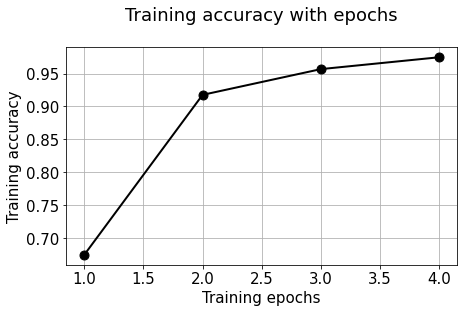

In [8]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(len(history.history['binary_accuracy']))], history.history['binary_accuracy'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

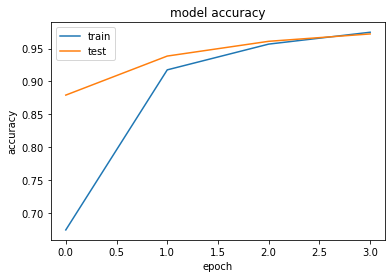

In [9]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


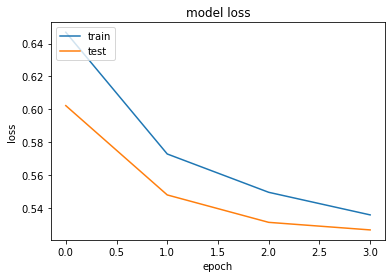

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
#import os
#PATH = os.getenv('PATH')
#%env PATH=/var/opt/anaconda3/anaconda/envs/tf_gpu/bin:$PATH
#%load_ext tensorboard
#%tensorboard --logdir notebook/logs --host groucho.renci.org --port 6006

In [12]:
with strategy.scope():
    # Unfreeze the base model
    base_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])
    history = model.fit(train_generator, epochs=10, callbacks = callbacks_list, steps_per_epoch=int(6000/batch_size),
              validation_data = validation_generator, validation_steps=int(2000/batch_size))

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
46/46 [==============================] - 692s 15s/step - binary_accuracy: 0.9980 - loss: 0.5060 - val_binary_accuracy: 1.0000 - val_loss: 0.5163 - lr: 1.0000e-05
Epoch 2/10
46/46 [==============================] - 651s 14s/step - binary_accuracy: 1.0000 - loss: 0.5035 - val_binary_accuracy: 1.0000 - val_loss: 0.5162 - lr: 1.0000e-05
Epoch 3/10
 2/46 [>.............................] - ETA: 22s - binary_accuracy: 1.0000 - loss: 0.5080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


46/46 [==============================] - 653s 14s/step - binary_accuracy: 1.0000 - loss: 0.5030 - val_binary_accuracy: 1.0000 - val_loss: 0.4902 - lr: 1.0000e-05


In [13]:
model.save('guardrail_xception_subset.h5')

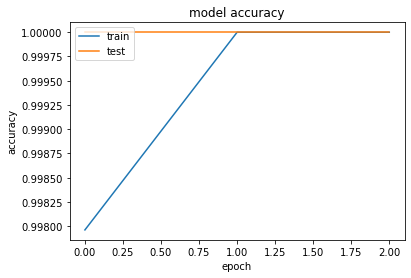

In [14]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

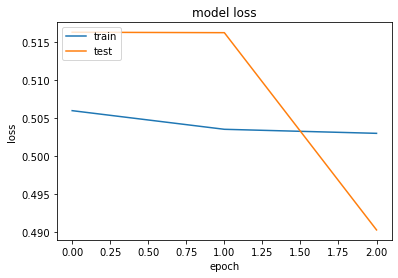

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
predictions = model.predict(test_generator, steps=int(2000/batch_size+1), verbose=1)
print(predictions)
print(test_generator.class_indices)
print(train_generator.class_indices)
print(validation_generator.class_indices)

16/16 [==============================] - 155s 10s/step
[[2.3242709e-08]
 [1.3973875e-07]
 [5.2035460e-07]
 ...
 [9.9998820e-01]
 [9.9996674e-01]
 [9.9989390e-01]]
{'guardrail_no': 0, 'guardrail_yes': 1}
{'guardrail_no': 0, 'guardrail_yes': 1}
{'guardrail_no': 0, 'guardrail_yes': 1}


In [17]:
y_pred = [1 if y[0] >= 0.5 else 0 for y in predictions]


In [18]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['guardrail_no', 'guardrail_yes']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1000    0]
 [   0 1000]]
Classification Report
               precision    recall  f1-score   support

 guardrail_no       1.00      1.00      1.00      1000
guardrail_yes       1.00      1.00      1.00      1000

     accuracy                           1.00      2000
    macro avg       1.00      1.00      1.00      2000
 weighted avg       1.00      1.00      1.00      2000

